In [1]:
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Specify the path to the fastai directory
lib_PATH = '/Users/kunal/Desktop/MSAN_Coursework/621_ML/fastai/fastai'   # Update this
!cd {lib_PATH}
# Create sym-link to the fastai library
!ln -s {lib_PATH} ./

ln: .//fastai: File exists


In [21]:
# Load required modules
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from dateutil.relativedelta import relativedelta

# Load Cleaned Data

In [5]:
train = pd.read_feather('../data/tmp/wsdm_train')
test = pd.read_feather('../data/tmp/wsdm_test')

In [6]:
train.columns[train.isnull().any()]

Index(['source_system_tab', 'source_screen_name', 'source_type', 'gender',
       'name'],
      dtype='object')

In [7]:
df, y, nas = proc_df(train, 'target')    # proc_df deals with na values

In [8]:
df.columns[df.isnull().any()]     # no nas left

Index([], dtype='object')

# Split into Training + Validation Sets

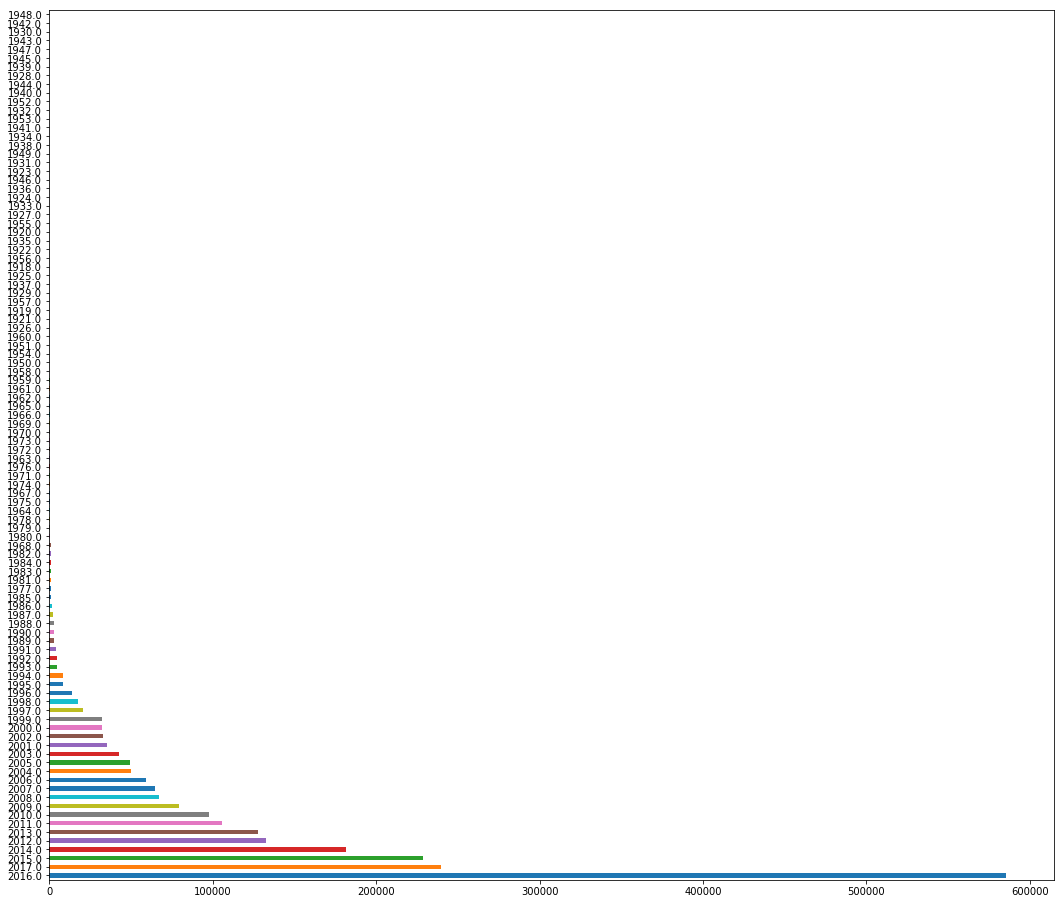

In [10]:
fig=plt.figure(figsize=(18, 16))
test.song_year.value_counts().plot.barh()

In [9]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()
# https://www.kaggle.com/kamilkk/i-have-to-say-this
# temporally ordered data - set val. set = test set's length
len_valid = len(test)
n_trn = len(df) - len_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((4820628, 35), (4820628,), (2556790, 35))

# Train the Random Forest

In [24]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    auc_trn   = roc_auc_score(y_train, m.predict(X_train))
    auc_valid = roc_auc_score(y_valid, m.predict(X_valid))
    res = [auc_trn, auc_valid, rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid), 
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print('auc_trn, auc_valid, RMSE - train, RMSE - valid, R^2 - train, R^2 - valid')
    print(res)

In [32]:
set_rf_samples(200000)

In [ ]:
m = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, n_jobs=-1, verbose=1)
%time m.fit(X_train, y_train)
print_score(m)